# Import Multiple Excel Files & Combine (Append) into Proper Data Set

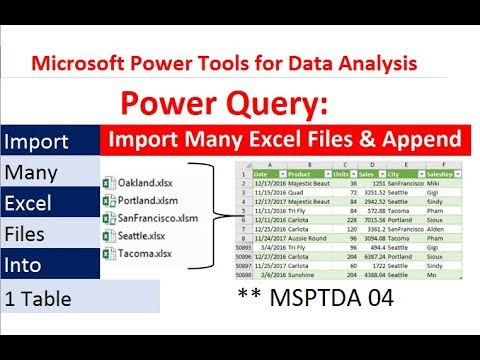

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo(id="rSQwZ1d3b1g", width=500, height=300)

## Input data

In [2]:
# https://people.highline.edu/mgirvin/AllClasses/348/MSPTDA/Content/PowerQuery/004-MSPTDA-ExcelFiles.zip
# https://people.highline.edu/mgirvin/AllClasses/348/MSPTDA/Content/PowerQuery/004-MSPTDA-StartFile-PowerQueryImportExcelFilesAppend.xlsx
# https://people.highline.edu/mgirvin/AllClasses/348/MSPTDA/Content/PowerQuery/SanJose.xlsx

# Alternative Pandas solution

## Concatenate Excel files 

In [3]:
import pandas as pd
import numpy as np
from glob import glob
from os.path import basename, splitext

data = []

for f in glob('inputs/004/*.xls*'):

    with pd.ExcelFile(f) as xlsx:
        sheet_names = [x for x in xlsx.sheet_names if x != 'Sheet1']
        
        for sheet in sheet_names:
            dx = xlsx.parse(sheet)
            dx['UnitPrice'] = dx['Sales'] / dx['Units']
            dx['City'] = splitext(basename(f))[0]
            dx['SalesRep'] = sheet
            data.append(dx)

df = pd.concat(data)

In [4]:
display(df.shape)
df.head()

(33119, 7)

,Date,Product,Units,Sales,UnitPrice,City,SalesRep
0,2016-11-21,Majestic Beaut,204,7364.40,36.10,Seattle,Sindy
1,2017-04-20,Bellen,252,7436.52,29.51,Seattle,Sindy
2,2017-05-26,Quad,168,7680.96,45.72,Seattle,Sindy
3,2017-11-29,Aussie Round,216,7063.20,32.70,Seattle,Sindy
4,2017-10-23,Aussie Round,132,4328.28,32.79,Seattle,Sindy


## Concatenate Excel files (enhanced)

In [5]:
def capture_meta_info(f, sheet, df):
    
    rows, cols = df.shape
    meta = {'file': f, 'sheet': sheet, 'rows': rows, 'cols': cols}
    logger.info(f"{meta.get('file')}, ({meta.get('sheet')}) {meta.get('rows')} rows")
    
    return meta

In [6]:
import pandas as pd
import numpy as np
import logging
from glob import glob
from os.path import basename, splitext

log_fmt = '%(asctime)s %(name)-4s %(levelname)-4s %(funcName)-4s %(message)s'
logging.basicConfig(level=logging.INFO, format=log_fmt, datefmt='%Y-%m-%d %H:%M:%S')
logger = logging.getLogger(__name__)

data, sheet_meta = [], []

for f in glob('inputs/004/*.xls*'):
    logger.debug(f'file: {f}')

    with pd.ExcelFile(f) as xlsx:
        sheet_names = [x for x in xlsx.sheet_names if x != 'Sheet1']
        
        for sheet in sheet_names:
            dx = xlsx.parse(sheet)
            dx['UnitPrice'] = dx['Sales'] / dx['Units']
            dx['City'] = splitext(basename(f))[0]
            dx['SalesRep'] = sheet
            data.append(dx)

            sheet_meta.append(capture_meta_info(f, sheet, dx))

df_meta = pd.DataFrame(sheet_meta)
df = pd.concat(data)
logger.info(f'Files concatenated, total rows processed: {df.shape[0]} rows.')

2021-03-29 21:20:47 __main__ INFO capture_meta_info inputs/004/Seattle.xlsx, (Sindy) 3695 rows
2021-03-29 21:20:47 __main__ INFO capture_meta_info inputs/004/Seattle.xlsx, (Mo) 3417 rows
2021-03-29 21:20:47 __main__ INFO capture_meta_info inputs/004/Seattle.xlsx, (Gigi) 3648 rows
2021-03-29 21:20:48 __main__ INFO capture_meta_info inputs/004/Portland.xlsm, (Sioux) 3584 rows
2021-03-29 21:20:48 __main__ INFO capture_meta_info inputs/004/Portland.xlsm, (Chin) 3719 rows
2021-03-29 21:20:48 __main__ INFO capture_meta_info inputs/004/Portland.xlsm, (Tyrone) 4023 rows
2021-03-29 21:20:48 __main__ INFO capture_meta_info inputs/004/Oakland.xlsx, (Fran) 3756 rows
2021-03-29 21:20:49 __main__ INFO capture_meta_info inputs/004/Oakland.xlsx, (Gab) 3589 rows
2021-03-29 21:20:49 __main__ INFO capture_meta_info inputs/004/Oakland.xlsx, (Popi) 3688 rows
2021-03-29 21:20:49 __main__ INFO <module> Files concatenated, total rows processed: 33119 rows.


In [7]:
# 
display(f'{df.shape[0]} rows')
df.head(2)

'33119 rows'

,Date,Product,Units,Sales,UnitPrice,City,SalesRep
0,2016-11-21,Majestic Beaut,204,7364.40,36.10,Seattle,Sindy
1,2017-04-20,Bellen,252,7436.52,29.51,Seattle,Sindy


In [8]:
df_meta

,file,sheet,rows,cols
0,inputs/004/Seattle.xlsx,Sindy,3695,7
1,inputs/004/Seattle.xlsx,Mo,3417,7
2,inputs/004/Seattle.xlsx,Gigi,3648,7
3,inputs/004/Portland.xlsm,Sioux,3584,7
4,inputs/004/Portland.xlsm,Chin,3719,7
5,inputs/004/Portland.xlsm,Tyrone,4023,7
6,inputs/004/Oakland.xlsx,Fran,3756,7
7,inputs/004/Oakland.xlsx,Gab,3589,7
8,inputs/004/Oakland.xlsx,Popi,3688,7


## Export data to Excel

In [9]:
xl_output = 'outputs/PandasDataSource.xlsx'
with pd.ExcelWriter(xl_output) as writer:
    df.to_excel(writer, sheet_name='s1', index=False, freeze_panes=(1,0))
    df_meta.to_excel(writer, sheet_name='s2', index=False, freeze_panes=(1,0))
    
logger.info(f'Written {xl_output}, completed.')

2021-03-29 21:20:54 __main__ INFO <module> Written outputs/PandasDataSource.xlsx, completed.


# Optional (aggregate analysis)

In [10]:
grouper = pd.Grouper(key='Date', freq='A')
index = ['Product', 'SalesRep', grouper]

query_select = ''' SalesRep.isin(['Gab', 'Popi', 'Fran']) '''
mask = df.query(query_select)

pv = mask.groupby(index).agg(Totals=pd.NamedAgg('Sales', 'sum'))
pv = pv.unstack().fillna(0)

# format_str = '%b %Y'
# format_str = '%d-%m-%Y'
format_str = '%Y'

pv.columns = [x[1].strftime(format_str) for x in pv.columns.values]
pv.head(10)

2016       2017
Product      SalesRep                      
Aspen        Fran      467009.16  412105.32
             Gab       417710.40  417904.32
             Popi      451153.56  501077.16
Aussie Round Fran      827780.28  826025.64
             Gab       935100.96  844470.72
             Popi      753466.80  787275.48
Bellen       Fran      809981.40  887012.52
             Gab       705972.12  823471.92
             Popi      727378.32  770892.72
Carlota      Fran      801009.84  662275.56

## Pivot table

In [11]:
# query_select = ''' Product != '' '''
# mask = df.query(query_select)

# grouper = pd.Grouper(key='Date', freq='A')
# index = ['SalesRep', 'Product', grouper]

# pv = df.pivot_table(index=index,
#                     columns='City',
#                     values='Sales',
#                     fill_value=0,
#                     aggfunc=np.sum)
# pv

## Groupby

In [12]:
# query_select = ''' Product != '' '''
# mask = df.query(query_select)

# grouper = pd.Grouper(key='Date', freq='A')
# index = ['SalesRep', 'Product', grouper, 'City']

# pv = df.groupby(index).agg(Totals=pd.NamedAgg('Sales', 'sum'))
# pv = pv.unstack().fillna(0)
# pv